# Rules

### Участникам предоставляется несколько наборов данных для решения этой задачи. Общие данные:

- clients.csv: информация о клиентах;
- products.csv: информация о товарах;
- purchases.csv: история покупок клиентов до момента рассылки.

### Данные, относящиеся непосредственно к задаче:

- uplift_train.csv: набор клиентов для обучения, с указанием treatment_flg — была ли совершена коммуникация, target — была ли совершена покупка после совершения коммуникации;
- uplift_test.csv: список клиентов, для которых необходимо оценить uplift;
- uplift_sample_submission.csv: пример файла с предсказаниями.

# Import

In [601]:
import pandas as pd
import numpy as np

import pandas_summary as ps
import pandas_profiling

import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc, math
from tqdm import tqdm
import pickle
import shap

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)

warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [602]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [603]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [604]:
# Чтение данных

df_clients = reduce_mem_usage(pd.read_csv('data/clients.csv', index_col='client_id'))
df_train = reduce_mem_usage(pd.read_csv('data/uplift_train.csv', index_col='client_id'))
df_test = reduce_mem_usage(pd.read_csv('data/uplift_test.csv', index_col='client_id'))
df_products = reduce_mem_usage(pd.read_csv('data/products.csv', index_col='product_id'))
df_sub = pd.read_csv('data/uplift_sample_submission.csv', index_col='client_id')
df_purchases = reduce_mem_usage(pd.read_csv('data/purchases.csv'))

Memory usage of dataframe is 15.26 MB
Memory usage after optimization is: 12.98 MB
Decreased by 15.0%
Memory usage of dataframe is 4.58 MB
Memory usage after optimization is: 1.91 MB
Decreased by 58.3%
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 1.53 MB
Decreased by 0.0%
Memory usage of dataframe is 3.61 MB
Memory usage after optimization is: 2.54 MB
Decreased by 29.5%
Memory usage of dataframe is 4541.21 MB
Memory usage after optimization is: 2445.27 MB
Decreased by 46.2%


In [605]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [606]:
dfs = ps.DataFrameSummary(df_clients)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['first_issue_date', 'first_redeem_date', 'gender']
numerics:  ['age']


,first_issue_date,first_redeem_date,age,gender
count,NaN,NaN,400162,NaN
mean,NaN,NaN,46.4881,NaN
std,NaN,NaN,43.8712,NaN
min,NaN,NaN,-7491,NaN
25%,NaN,NaN,34,NaN
50%,NaN,NaN,45,NaN
75%,NaN,NaN,59,NaN
max,NaN,NaN,1901,NaN
counts,400162,364693,400162,400162
uniques,396725,362527,290,3


In [607]:
df_train.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


In [608]:
dfs = ps.DataFrameSummary(df_train)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  []
numerics:  []


,treatment_flg,target
count,200039,200039
mean,0.499808,0.619889
std,0.500001,0.485415
min,0,0
25%,0,0
50%,0,1
75%,1,1
max,1,1
counts,200039,200039
uniques,2,2


In [609]:
df_test.head()

""
client_id
000048b7a6
000073194a
00007c7133
00007f9014
0000a90cf7


In [610]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [611]:
dfs = ps.DataFrameSummary(df_purchases)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['client_id', 'transaction_id', 'transaction_datetime', 'store_id', 'product_id']
numerics:  ['regular_points_received', 'express_points_received', 'regular_points_spent', 'express_points_spent', 'purchase_sum', 'product_quantity', 'trn_sum_from_iss', 'trn_sum_from_red']


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
count,NaN,NaN,NaN,4.57866e+07,4.57866e+07,4.57866e+07,4.57866e+07,4.57866e+07,NaN,NaN,4.57866e+07,4.57866e+07,3.04336e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,0,0,-5064,-300,0,NaN,NaN,0,0,0
25%,NaN,NaN,NaN,1.40039,0,0,0,286,NaN,NaN,1,30,31
50%,NaN,NaN,NaN,3.80078,0,0,0,539,NaN,NaN,1,51,55
75%,NaN,NaN,NaN,10.2969,0,0,0,976,NaN,NaN,1,90,95
max,NaN,NaN,NaN,2400,300,0,0,35136,NaN,NaN,14944,35136,8792
counts,45786568,45786568,45786568,45786568,45786568,45786568,45786568,45786568,45786568,45786568,45786568,45786568,3043356
uniques,400162,8045201,4260251,2115,13,1147,78,10387,13882,42530,166,3038,1427


In [612]:
df_products.head()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
product_id,,,,,,,,,,
0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.399902,0,0
0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680176,0,0
0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500000,0,0
000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112000,0,0
0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600098,0,0


In [613]:
dfs = ps.DataFrameSummary(df_products)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['level_1', 'level_2', 'level_3', 'level_4', 'brand_id', 'vendor_id']
numerics:  ['segment_id', 'netto']


,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
count,NaN,NaN,NaN,NaN,41466,NaN,NaN,43035,43038,43038
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537109,0.0351782,0.055602
std,NaN,NaN,NaN,NaN,82.25,NaN,NaN,NaN,0.184232,0.229154
min,NaN,NaN,NaN,NaN,1,NaN,NaN,0,0,0
25%,NaN,NaN,NaN,NaN,105,NaN,NaN,0.150024,0,0
50%,NaN,NaN,NaN,NaN,148,NaN,NaN,0.300049,0,0
75%,NaN,NaN,NaN,NaN,214,NaN,NaN,0.5,0,0
max,NaN,NaN,NaN,NaN,321,NaN,NaN,1150,1,1
counts,43035,43035,43035,43035,41466,37838,43004,43035,43038,43038
uniques,3,42,201,790,116,4296,3193,778,2,2


# Age correction

In [614]:
df_clients[(df_clients['age'] >= 9) & (df_clients['age'] <= 85)]

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U
...,...,...,...,...
fffece623e,2018-05-13 15:09:30,2018-12-27 19:06:39,67,U
ffff3dfff8,2018-11-01 16:06:52,2018-12-07 17:33:47,56,F
ffffaab9da,2017-08-25 18:43:24,2017-12-08 17:53:19,23,F


In [615]:
gender_m = df_clients[(df_clients['age'] >= 9) & (df_clients['age'] <= 85) & (df_clients['gender'] == 'M')]['age'].median()
gender_u = df_clients[(df_clients['age'] >= 9) & (df_clients['age'] <= 85) & (df_clients['gender'] == 'U')]['age'].median()
gender_f = df_clients[(df_clients['age'] >= 9) & (df_clients['age'] <= 85) & (df_clients['gender'] == 'F')]['age'].median()
gender_m, gender_f, gender_u

(40.0, 47.0, 46.0)

In [616]:
df_clients.loc[((df_clients['age'] < 9) | (df_clients['age'] > 85)) & (df_clients['gender'] == 'U'), 'age'] = gender_u 
df_clients.loc[((df_clients['age'] < 9) | (df_clients['age'] > 85)) & (df_clients['gender'] == 'M'), 'age'] = gender_m 
df_clients.loc[((df_clients['age'] < 9) | (df_clients['age'] > 85)) & (df_clients['gender'] == 'F'), 'age'] = gender_f

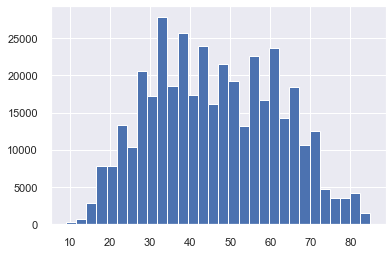

In [617]:
df_clients['age'].hist(bins=30)

# Gender mean encoding

In [618]:
from sklearn.base import BaseEstimator

class MeanEncoding(BaseEstimator):
    """
    Здесь мы делаем самый простой targetencoding - сложный и удобный пойдет в домашнее задание
    """
    
    def __init__(self, feature, C=0.1):
        self.C = C
        self.feature = feature
        
    def fit(self, X_train, y_train):
        
        df = pd.DataFrame({'feature': X_train[self.feature], 'target': y_train}).dropna()
        
        self.global_mean = df.target.mean()
        mean = df.groupby('feature').target.mean()
        size = df.groupby('feature').target.size()
        
        self.encoding = (self.global_mean * self.C + mean * size) / (self.C + size)
    
    def transform(self, X_test):
        
        X_test[self.feature] = X_test[self.feature].map(self.encoding).fillna(self.global_mean).values
        
        return X_test
    
    def fit_transform(self, X_train, y_train):
        
        df = pd.DataFrame({'feature': X_train[self.feature], 'target': y_train}).dropna()
        
        self.global_mean = df.target.mean()
        mean = df.groupby('feature').target.mean()
        size = df.groupby('feature').target.size()
        self.encoding = (self.global_mean * self.C + mean * size) / (self.C + size)
        
        X_train[self.feature] = X_train[self.feature].map(self.encoding).fillna(self.global_mean).values
        
        return X_train

In [619]:
tmp_df = df_clients.merge(df_train, how='inner', left_on=['client_id'], right_on=['client_id'])
me = MeanEncoding('gender', C=1)
me.fit(tmp_df, tmp_df['target'])
df_clients = me.transform(df_clients)
df_clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,0.602885
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,0.640604
000048b7a6,2018-12-15 13:33:11,NaN,68.0,0.640604
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60.0,0.640604
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67.0,0.602885


## Clients first issue date & first redeem date

In [620]:
df_clients['first_issue_unixtime'] = pd.to_datetime(df_clients['first_issue_date']).values.astype(int)/10**9
df_clients['first_redeem_unixtime'] = pd.to_datetime(df_clients['first_redeem_date']).values.astype(int)/10**9

In [621]:
df_clients.loc[df_clients['first_redeem_unixtime'] == 0, 'first_redeem_unixtime'] = \
df_clients[df_clients['first_redeem_unixtime'] != 0]['first_redeem_unixtime'].median()

## Transactions Count

In [622]:
# client transactions count
tmp_df = pd.DataFrame(df_purchases.groupby(['client_id', 
                     'transaction_id']).agg('count').reset_index().groupby(['client_id'])['transaction_id'].agg('count'))
tmp_df.columns = ['transactions_count']
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [623]:
del tmp_df
gc.collect()

132

## Positions in transactions Count

In [624]:
# client positions count
tmp_df = pd.DataFrame(df_purchases.groupby(['client_id'])['transaction_id'].agg('count'))
tmp_df.columns = ['positions_count']
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [625]:
del tmp_df
gc.collect()

40

## Stores Count

In [626]:
# client stores count
tmp_df = pd.DataFrame(df_purchases.groupby(['client_id', 
                     'store_id']).agg('count').reset_index().groupby(['client_id'])['store_id'].agg('count'))
tmp_df.columns = ['stores_count']
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [627]:
del tmp_df
gc.collect()

0

## Products Count

In [628]:
# client products count
tmp_df = pd.DataFrame(df_purchases.groupby(['client_id', 
                     'product_id']).agg('count').reset_index().groupby(['client_id'])['product_id'].agg('count'))
tmp_df.columns = ['products_count']
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [629]:
del tmp_df
gc.collect()

40

In [630]:
df_clients['tran_div_pos'] = df_clients['transactions_count'] / df_clients['positions_count']
df_clients['tran_div_stores'] = df_clients['transactions_count'] / df_clients['stores_count']
df_clients['tran_div_prod'] = df_clients['transactions_count'] / df_clients['products_count']
df_clients['stores_div_pos'] = df_clients['stores_count'] / df_clients['positions_count']
df_clients['stores_div_prod'] = df_clients['stores_count'] / df_clients['products_count']

In [631]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender,first_issue_unixtime,first_redeem_unixtime,transactions_count,positions_count,stores_count,products_count,tran_div_pos,tran_div_stores,tran_div_prod,stores_div_pos,stores_div_prod
client_id,,,,,,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,0.602885,-1.639580,1.769781,4,52,3,46,0.076923,1.333333,0.086957,0.057692,0.065217
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,0.640604,-1.786588,-0.133929,32,162,5,96,0.197531,6.400000,0.333333,0.030864,0.052083
000048b7a6,2018-12-15 13:33:11,NaN,68.0,0.640604,-0.270457,0.003494,8,56,2,44,0.142857,4.000000,0.181818,0.035714,0.045455
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60.0,0.640604,-1.523791,-1.793599,17,82,1,68,0.207317,17.000000,0.250000,0.012195,0.014706
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67.0,0.602885,-1.639897,1.653310,11,83,2,64,0.132530,5.500000,0.171875,0.024096,0.031250


## Transactions datetime

In [632]:
df_purchases['transaction_datetime_unixtime'] = pd.to_datetime(df_purchases['transaction_datetime']).values.astype(int)/10**9
tmp_df = pd.DataFrame(df_purchases.groupby(['client_id', 'transaction_id', 'transaction_datetime_unixtime', 
             ]).agg('count').reset_index().groupby(['client_id'])['transaction_datetime_unixtime'].agg((min, max, 
                                                                  np.mean, np.median, np.sum, np.std)))
tmp_df.columns = list(map(lambda c: 'transaction_datetime_' + c, tmp_df.columns))
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [633]:
tmp_df.head()

,transaction_datetime_min,transaction_datetime_max,transaction_datetime_mean,transaction_datetime_median,transaction_datetime_sum,transaction_datetime_std
client_id,,,,,,
000012768d,-2.014181,1.710228,0.386541,0.925059,1.546164,1.646846
000036f903,-2.102884,2.096958,0.120878,0.251458,3.868092,1.181105
000048b7a6,-1.230589,2.092589,0.480238,0.806106,3.841900,1.276268
000073194a,-2.114125,1.988136,0.465784,0.349408,7.918334,1.249318
00007c7133,-1.655857,1.998814,0.681337,0.653554,7.494705,1.152909


In [634]:
del tmp_df
gc.collect()

40

In [635]:
df_clients['first_redeem_tran_med'] = df_clients['first_redeem_unixtime'] - df_clients['transaction_datetime_median']
df_clients['first_redeem_tran_min'] = df_clients['first_redeem_unixtime'] - df_clients['transaction_datetime_min']
df_clients['first_redeem_tran_max'] = df_clients['first_redeem_unixtime'] - df_clients['transaction_datetime_max']

## Purchases stats

In [636]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender,first_issue_unixtime,first_redeem_unixtime,transactions_count,positions_count,stores_count,products_count,tran_div_pos,tran_div_stores,tran_div_prod,stores_div_pos,stores_div_prod,transaction_datetime_min,transaction_datetime_max,transaction_datetime_mean,transaction_datetime_median,transaction_datetime_sum,transaction_datetime_std,first_redeem_tran_med,first_redeem_tran_min,first_redeem_tran_max
client_id,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,0.602885,-1.639580,1.769781,4,52,3,46,0.076923,1.333333,0.086957,0.057692,0.065217,-2.014181,1.710228,0.386541,0.925059,1.546164,1.646846,0.844722,3.783962,0.059553
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,0.640604,-1.786588,-0.133929,32,162,5,96,0.197531,6.400000,0.333333,0.030864,0.052083,-2.102884,2.096958,0.120878,0.251458,3.868092,1.181105,-0.385387,1.968955,-2.230887
000048b7a6,2018-12-15 13:33:11,NaN,68.0,0.640604,-0.270457,0.003494,8,56,2,44,0.142857,4.000000,0.181818,0.035714,0.045455,-1.230589,2.092589,0.480238,0.806106,3.841900,1.276268,-0.802612,1.234083,-2.089095
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60.0,0.640604,-1.523791,-1.793599,17,82,1,68,0.207317,17.000000,0.250000,0.012195,0.014706,-2.114125,1.988136,0.465784,0.349408,7.918334,1.249318,-2.143007,0.320526,-3.781735
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67.0,0.602885,-1.639897,1.653310,11,83,2,64,0.132530,5.500000,0.171875,0.024096,0.031250,-1.655857,1.998814,0.681337,0.653554,7.494705,1.152909,0.999756,3.309167,-0.345504


# Products

In [637]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,transaction_datetime_unixtime
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,1.710228
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,1.710228
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,1.710228
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,1.710228
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,1.710228


In [638]:
df_purchases = df_purchases.merge(df_products.reset_index(), how='left', left_on=['product_id'], right_on=['product_id'])

In [639]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,transaction_datetime_unixtime,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,1.710228,e344ab2e71,ed2ad1797c,b25baa9dd5,51647c28e9,116.0,082560ca58,63243765ed,0.031006,0,0
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,1.710228,e344ab2e71,ed2ad1797c,0767853bf3,eaeb795060,14.0,cab440afaf,43acd80c1a,0.399902,1,0
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,1.710228,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,be9c719ecd,c7609af7c3,0.229980,0,0
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,1.710228,c3d3a8e8c6,ad2b2e17d2,ca69ed9de2,c42bee16c3,69.0,f82b1d6eaa,3034fb4c4a,0.150024,0,0
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,1.710228,e344ab2e71,52f13dac0c,0f84eb7480,420c3b3f0b,150.0,032202eff9,ca1ac137e8,0.080017,0,0


In [640]:
# client purchases stats
cols4groupby = ['client_id', 'regular_points_received', 'regular_points_spent', 'express_points_spent', 'purchase_sum']
tmp_df = pd.DataFrame(df_purchases.groupby(['client_id', 
                     'transaction_id']).agg(np.mean).reset_index()[cols4groupby].groupby(['client_id']).agg((np.sum)))
tmp_df.columns = list(map(lambda c: c+'_sum', tmp_df.columns.tolist()))
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [641]:
tmp_df.head()

,regular_points_received_sum,regular_points_spent_sum,express_points_spent_sum,purchase_sum_sum
client_id,,,,
000012768d,25.703125,0.0,0.0,2804.0
000036f903,54.906250,0.0,0.0,9808.0
000048b7a6,26.500000,0.0,0.0,3772.0
000073194a,74.875000,-96.0,0.0,9600.0
00007c7133,56.593750,-240.0,0.0,6720.0


In [642]:
del tmp_df
gc.collect()

80

In [643]:
dfs.summary()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
count,NaN,NaN,NaN,NaN,41466,NaN,NaN,43035,43038,43038
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537109,0.0351782,0.055602
std,NaN,NaN,NaN,NaN,82.25,NaN,NaN,NaN,0.184232,0.229154
min,NaN,NaN,NaN,NaN,1,NaN,NaN,0,0,0
25%,NaN,NaN,NaN,NaN,105,NaN,NaN,0.150024,0,0
50%,NaN,NaN,NaN,NaN,148,NaN,NaN,0.300049,0,0
75%,NaN,NaN,NaN,NaN,214,NaN,NaN,0.5,0,0
max,NaN,NaN,NaN,NaN,321,NaN,NaN,1150,1,1
counts,43035,43035,43035,43035,41466,37838,43004,43035,43038,43038
uniques,3,42,201,790,116,4296,3193,778,2,2


## Calculate trn_sum_from_sum

In [644]:
df_purchases['trn_sum_from_sum'] = df_purchases.fillna(0)['trn_sum_from_iss'] + df_purchases.fillna(0)['trn_sum_from_red']

## trn_sum_from_sum  4  is_own_trademark - np.sum, np.mean, np.min

In [645]:
tmp_df = df_purchases[df_purchases['is_own_trademark']==1][['client_id', 
                                   'trn_sum_from_sum']].fillna(0).groupby(['client_id']).agg([np.sum, np.mean, np.min])
tmp_df.columns = list(map(lambda c: 'trademark'+'_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [646]:
tmp_df.head()

,trademarktrn_sum_from_sum_sum,trademarktrn_sum_from_sum_mean,trademarktrn_sum_from_sum_amin
client_id,,,
000012768d,275.0,68.75000,50.0
000036f903,1051.0,75.06250,17.0
000048b7a6,393.0,131.00000,40.0
000073194a,63.0,21.00000,5.0
00007c7133,381.0,38.09375,5.0


In [647]:
del tmp_df
gc.collect()

40

## trn_sum_from_sum  4  is_alcohol - np.sum, np.mean, np.min

In [648]:
tmp_df = df_purchases[df_purchases['is_alcohol']==1][['client_id', 
                                   'trn_sum_from_sum']].fillna(0).groupby(['client_id']).agg([np.sum, np.mean, np.min])
tmp_df.columns = list(map(lambda c: 'alcohol'+'_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [649]:
tmp_df.head()

,alcoholtrn_sum_from_sum_sum,alcoholtrn_sum_from_sum_mean,alcoholtrn_sum_from_sum_amin
client_id,,,
000036f903,229.0,229.0000,229.0
000073194a,3252.0,361.5000,250.0
0000a90cf7,345.0,172.5000,100.0
0000b59cec,1509.0,116.0625,77.0
0000bcec9c,1264.0,316.0000,230.0


In [650]:
del tmp_df
gc.collect()

40

## percent 4 trn_sum_from_red

In [651]:
tmp_df = df_purchases.fillna(0)[['client_id', 'trn_sum_from_red', 'trn_sum_from_sum']].groupby(['client_id']).agg([np.sum])
tmp_df.columns = list(map(lambda c: '_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))
tmp_df['percent_trn_sum_from_red'] = tmp_df['trn_sum_from_red_sum'] / tmp_df['trn_sum_from_sum_sum']
tmp_df = tmp_df[['percent_trn_sum_from_red']]
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])

In [652]:
del tmp_df
gc.collect()

20

In [653]:
tmp_df = df_purchases.copy()[['client_id', 'segment_id', 
                       'trn_sum_from_iss']].groupby(['client_id', 'segment_id']).agg([np.sum]).reset_index()
tmp_df.columns = ['client_id', 'segment_id', 'trn_sum_from_iss']
tmp_df['trn_sum_from_iss'].fillna(0, inplace=True)
tmp_df['segment_id'].fillna(-99, inplace=True)
tmp_df['trn_sum_from_iss'] = tmp_df['trn_sum_from_iss'].astype('int32')
tmp_df = pd.DataFrame(pd.pivot_table(tmp_df, values=['trn_sum_from_iss'], index=['client_id'], columns=['segment_id'], 
                                             aggfunc={'trn_sum_from_iss': [np.sum]}, fill_value=0))
tmp_df.columns = list(map(lambda c: '_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))

In [654]:
n_comp = 20
tmp_df = pd.DataFrame(StandardScaler().fit_transform(tmp_df), index=tmp_df.index)
svd = PCA(n_components=n_comp, random_state=777).fit(tmp_df)
tmp_df = pd.DataFrame(svd.transform(tmp_df), index=tmp_df.index, columns=['segment_trnsum_pca_'+str(i) for i in range(n_comp)])
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

,segment_trnsum_pca_0,segment_trnsum_pca_1,segment_trnsum_pca_2,segment_trnsum_pca_3,segment_trnsum_pca_4,segment_trnsum_pca_5,segment_trnsum_pca_6,segment_trnsum_pca_7,segment_trnsum_pca_8,segment_trnsum_pca_9,segment_trnsum_pca_10,segment_trnsum_pca_11,segment_trnsum_pca_12,segment_trnsum_pca_13,segment_trnsum_pca_14,segment_trnsum_pca_15,segment_trnsum_pca_16,segment_trnsum_pca_17,segment_trnsum_pca_18,segment_trnsum_pca_19
client_id,,,,,,,,,,,,,,,,,,,,
000012768d,-2.353685,0.289532,-0.284555,-0.245925,0.806839,-0.153469,-0.105824,0.454120,0.534197,-0.149144,0.038897,0.042134,-0.531342,0.347307,-0.015243,0.041963,0.103225,0.238347,-0.387939,-0.471312
000036f903,0.980391,0.791703,-0.213064,-2.231713,2.590549,-0.756215,0.513590,-1.696771,-0.448978,1.578514,-0.556341,-0.268577,-0.644248,1.672728,0.621165,0.416184,-0.897874,-1.197601,0.090381,0.244500
000048b7a6,-2.347279,-0.134517,0.544306,0.004077,-0.281858,-0.564934,-1.071682,-0.931246,-0.848934,-0.054860,0.367794,1.535127,0.107602,-0.665304,-1.016627,-0.404914,0.222434,0.266964,0.472045,-0.062579
000073194a,-0.212742,0.441555,0.799404,0.959985,-2.342171,-0.469213,-0.606379,0.271027,-0.670514,0.012516,-0.826918,-0.153459,0.373446,-0.065946,-0.421999,0.834555,1.463251,-0.442490,-0.072170,0.149921
00007c7133,-0.361955,0.294456,0.768739,-0.637166,-0.993797,-0.040298,-1.175603,-1.228489,0.168064,-1.371204,-0.717778,1.231626,0.270121,-0.584286,0.554374,0.129055,-0.206110,-0.120784,-0.534163,-0.339996


In [655]:
del tmp_df
gc.collect()

40

n_comp = 15
svd = TruncatedSVD(n_components=n_comp, random_state=777).fit(tmp_df)
tmp_df = pd.DataFrame(svd.transform(tmp_df), index=tmp_df.index, columns=['segment_trnsum_svd_'+str(i) for i in range(n_comp)])
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

In [656]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender,first_issue_unixtime,first_redeem_unixtime,transactions_count,positions_count,stores_count,products_count,tran_div_pos,tran_div_stores,tran_div_prod,stores_div_pos,stores_div_prod,transaction_datetime_min,transaction_datetime_max,transaction_datetime_mean,transaction_datetime_median,transaction_datetime_sum,transaction_datetime_std,first_redeem_tran_med,first_redeem_tran_min,first_redeem_tran_max,regular_points_received_sum,regular_points_spent_sum,express_points_spent_sum,purchase_sum_sum,trademarktrn_sum_from_sum_sum,trademarktrn_sum_from_sum_mean,trademarktrn_sum_from_sum_amin,alcoholtrn_sum_from_sum_sum,alcoholtrn_sum_from_sum_mean,alcoholtrn_sum_from_sum_amin,percent_trn_sum_from_red,segment_trnsum_pca_0,segment_trnsum_pca_1,segment_trnsum_pca_2,segment_trnsum_pca_3,segment_trnsum_pca_4,segment_trnsum_pca_5,segment_trnsum_pca_6,segment_trnsum_pca_7,segment_trnsum_pca_8,segment_trnsum_pca_9,segment_trnsum_pca_10,segment_trnsum_pca_11,segment_trnsum_pca_12,segment_trnsum_pca_13,segment_trnsum_pca_14,segment_trnsum_pca_15,segment_trnsum_pca_16,segment_trnsum_pca_17,segment_trnsum_pca_18,segment_trnsum_pca_19
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,0.602885,-1.639580,1.769781,4,52,3,46,0.076923,1.333333,0.086957,0.057692,0.065217,-2.014181,1.710228,0.386541,0.925059,1.546164,1.646846,0.844722,3.783962,0.059553,25.703125,0.0,0.0,2804.0,275.0,68.75000,50.0,NaN,NaN,NaN,0.00000,-2.353685,0.289532,-0.284555,-0.245925,0.806839,-0.153469,-0.105824,0.454120,0.534197,-0.149144,0.038897,0.042134,-0.531342,0.347307,-0.015243,0.041963,0.103225,0.238347,-0.387939,-0.471312
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,0.640604,-1.786588,-0.133929,32,162,5,96,0.197531,6.400000,0.333333,0.030864,0.052083,-2.102884,2.096958,0.120878,0.251458,3.868092,1.181105,-0.385387,1.968955,-2.230887,54.906250,0.0,0.0,9808.0,1051.0,75.06250,17.0,229.0,229.0,229.0,0.00000,0.980391,0.791703,-0.213064,-2.231713,2.590549,-0.756215,0.513590,-1.696771,-0.448978,1.578514,-0.556341,-0.268577,-0.644248,1.672728,0.621165,0.416184,-0.897874,-1.197601,0.090381,0.244500
000048b7a6,2018-12-15 13:33:11,NaN,68.0,0.640604,-0.270457,0.003494,8,56,2,44,0.142857,4.000000,0.181818,0.035714,0.045455,-1.230589,2.092589,0.480238,0.806106,3.841900,1.276268,-0.802612,1.234083,-2.089095,26.500000,0.0,0.0,3772.0,393.0,131.00000,40.0,NaN,NaN,NaN,0.00000,-2.347279,-0.134517,0.544306,0.004077,-0.281858,-0.564934,-1.071682,-0.931246,-0.848934,-0.054860,0.367794,1.535127,0.107602,-0.665304,-1.016627,-0.404914,0.222434,0.266964,0.472045,-0.062579
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60.0,0.640604,-1.523791,-1.793599,17,82,1,68,0.207317,17.000000,0.250000,0.012195,0.014706,-2.114125,1.988136,0.465784,0.349408,7.918334,1.249318,-2.143007,0.320526,-3.781735,74.875000,-96.0,0.0,9600.0,63.0,21.00000,5.0,3252.0,361.5,250.0,0.01358,-0.212742,0.441555,0.799404,0.959985,-2.342171,-0.469213,-0.606379,0.271027,-0.670514,0.012516,-0.826918,-0.153459,0.373446,-0.065946,-0.421999,0.834555,1.463251,-0.442490,-0.072170,0.149921
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67.0,0.602885,-1.639897,1.653310,11,83,2,64,0.132530,5.500000,0.171875,0.024096,0.031250,-1.655857,1.998814,0.681337,0.653554,7.494705,1.152909,0.999756,3.309167,-0.345504,56.593750,-240.0,0.0,6720.0,381.0,38.09375,5.0,NaN,NaN,NaN,0.07843,-0.361955,0.294456,0.768739,-0.637166,-0.993797,-0.040298,-1.175603,-1.228489,0.168064,-1.371204,-0.717778,1.231626,0.270121,-0.584286,0.554374,0.129055,-0.206110,-0.120784,-0.534163,-0.339996


## Transaction weekday

In [657]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red,transaction_datetime_unixtime,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol,trn_sum_from_sum
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN,1.710228,e344ab2e71,ed2ad1797c,b25baa9dd5,51647c28e9,116.0,082560ca58,63243765ed,0.031006,0,0,80.0
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN,1.710228,e344ab2e71,ed2ad1797c,0767853bf3,eaeb795060,14.0,cab440afaf,43acd80c1a,0.399902,1,0,65.0
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN,1.710228,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,be9c719ecd,c7609af7c3,0.229980,0,0,24.0
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN,1.710228,c3d3a8e8c6,ad2b2e17d2,ca69ed9de2,c42bee16c3,69.0,f82b1d6eaa,3034fb4c4a,0.150024,0,0,50.0
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN,1.710228,e344ab2e71,52f13dac0c,0f84eb7480,420c3b3f0b,150.0,032202eff9,ca1ac137e8,0.080017,0,0,22.0


In [658]:
df_purchases['transaction_weekday'] = pd.to_datetime(df_purchases['transaction_datetime']).dt.weekday

In [659]:
tmp_df = df_purchases.copy()[['client_id', 'transaction_weekday',  
                       'trn_sum_from_sum']].groupby(['client_id', 'transaction_weekday']).agg([np.sum]).reset_index()
tmp_df.columns = ['client_id', 'transaction_weekday', 'trn_sum_from_sum']
tmp_df['trn_sum_from_sum'].fillna(0, inplace=True)
tmp_df['trn_sum_from_sum'] = tmp_df['trn_sum_from_sum'].astype('int32')
tmp_df = pd.DataFrame(pd.pivot_table(tmp_df, values=['trn_sum_from_sum'], index=['client_id'], 
                                     columns=['transaction_weekday'], 
                                     aggfunc={'trn_sum_from_sum': [np.max]}, fill_value=0))
tmp_df.columns = list(map(lambda c: 'weekday_'+'_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))
#df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

,weekday_trn_sum_from_sum_amax_0,weekday_trn_sum_from_sum_amax_1,weekday_trn_sum_from_sum_amax_2,weekday_trn_sum_from_sum_amax_3,weekday_trn_sum_from_sum_amax_4,weekday_trn_sum_from_sum_amax_5,weekday_trn_sum_from_sum_amax_6
client_id,,,,,,,
000012768d,0,0,0,419,804,1007,575
000036f903,815,2560,1550,703,1422,243,2516
000048b7a6,114,816,1126,357,0,700,504
000073194a,1150,0,320,2154,2696,2048,1276
00007c7133,1245,1001,730,762,1044,1214,1044


In [660]:
n_comp = 3
tmp_df = pd.DataFrame(StandardScaler().fit_transform(tmp_df), index=tmp_df.index)
svd = PCA(n_components=n_comp, random_state=777).fit(tmp_df)
tmp_df = pd.DataFrame(svd.transform(tmp_df), index=tmp_df.index, columns=['weekday_trn_sum_pca_'+str(i) for i in range(n_comp)])
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

,weekday_trn_sum_pca_0,weekday_trn_sum_pca_1,weekday_trn_sum_pca_2
client_id,,,
000012768d,-1.345970,0.416312,-0.202239
000036f903,0.265854,-0.127045,-0.093955
000048b7a6,-1.066611,-0.020109,-0.057724
000073194a,0.019402,0.399728,-0.302497
00007c7133,-0.409176,0.018895,0.137249


In [661]:
del tmp_df
gc.collect()

40

In [662]:
tmp_df = df_purchases.copy()[['client_id', 'level_2',  
                       'regular_points_received']].groupby(['client_id', 'level_2']).agg([np.max]).reset_index()
tmp_df.columns = ['client_id', 'level_2', 'regular_points_received']
tmp_df['regular_points_received'].fillna(0, inplace=True)
tmp_df['regular_points_received'] = tmp_df['regular_points_received'].astype('int32')
tmp_df = pd.DataFrame(pd.pivot_table(tmp_df, values=['regular_points_received'], index=['client_id'], 
                                     columns=['level_2'], 
                                     aggfunc={'regular_points_received': [np.sum]}, fill_value=0))
tmp_df.columns = list(map(lambda c: 'level_2_'+'_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))
#df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

,level_2_regular_points_received_sum_034aca0659,level_2_regular_points_received_sum_14d373dff5,level_2_regular_points_received_sum_15e7af62dd,level_2_regular_points_received_sum_1d2939ba1d,level_2_regular_points_received_sum_26ae5a7da8,level_2_regular_points_received_sum_2ede06c1ee,level_2_regular_points_received_sum_35642addd4,level_2_regular_points_received_sum_36bd2cad67,level_2_regular_points_received_sum_3ef03403a0,level_2_regular_points_received_sum_3f9010c11e,level_2_regular_points_received_sum_4202626fcb,level_2_regular_points_received_sum_428e08386e,level_2_regular_points_received_sum_52f13dac0c,level_2_regular_points_received_sum_63852cb2ab,level_2_regular_points_received_sum_6b4ae3f25d,level_2_regular_points_received_sum_6f624f4be0,level_2_regular_points_received_sum_703f4b6eb0,level_2_regular_points_received_sum_70ac384d6a,level_2_regular_points_received_sum_749c619457,level_2_regular_points_received_sum_79666b6e44,level_2_regular_points_received_sum_825fe699ab,level_2_regular_points_received_sum_8a277809e5,level_2_regular_points_received_sum_91fb12a54a,level_2_regular_points_received_sum_93073a7304,level_2_regular_points_received_sum_a2963967ff,level_2_regular_points_received_sum_a49a930a49,level_2_regular_points_received_sum_a75f1bad01,level_2_regular_points_received_sum_ad2b2e17d2,level_2_regular_points_received_sum_b0c4967fce,level_2_regular_points_received_sum_be86806c6b,level_2_regular_points_received_sum_c2a3ea8d5e,level_2_regular_points_received_sum_c3d6b407d9,level_2_regular_points_received_sum_c6e84cdac8,level_2_regular_points_received_sum_d283080a93,level_2_regular_points_received_sum_de6f3b925a,level_2_regular_points_received_sum_e8705574ff,level_2_regular_points_received_sum_ed2ad1797c,level_2_regular_points_received_sum_f2333c90fb,level_2_regular_points_received_sum_f93982269d,level_2_regular_points_received_sum_f980df59e1,level_2_regular_points_received_sum_fb3d79909e,level_2_regular_points_received_sum_fb84f08028
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,10,10,0,0,0,0,0,0,0,0,0,0,10,0,0,0,10,0,0,0,0,0,0,0,5,0,0,10,0,0,5,0,0,0,0,0,10,0,0,0,0,0
000036f903,7,6,0,0,0,0,0,0,0,0,0,7,7,0,0,0,7,0,3,0,0,0,0,0,3,0,0,7,0,0,6,0,0,0,3,0,7,2,0,0,0,0
000048b7a6,2,2,0,0,0,0,0,0,5,0,0,0,0,1,0,0,11,0,0,0,0,0,0,0,11,0,0,11,0,0,11,0,0,0,0,0,11,0,0,0,11,0
000073194a,14,5,0,17,0,0,0,4,0,0,0,0,4,0,0,0,0,0,8,0,0,0,0,0,8,0,0,17,5,0,0,0,0,4,4,0,17,17,17,0,0,0
00007c7133,10,7,0,10,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,10,0,0,10,1,0,7,0,0,10,2,0,10,0,1,7,1,0


In [663]:
n_comp = 5
tmp_df = pd.DataFrame(StandardScaler().fit_transform(tmp_df), index=tmp_df.index)
svd = PCA(n_components=n_comp, random_state=777).fit(tmp_df)
tmp_df = pd.DataFrame(svd.transform(tmp_df), index=tmp_df.index, columns=['level_2_pca_'+str(i) for i in range(n_comp)])
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

,level_2_pca_0,level_2_pca_1,level_2_pca_2,level_2_pca_3,level_2_pca_4
client_id,,,,,
000012768d,-1.380463,-0.166942,-0.051064,-0.074364,0.037616
000036f903,-1.419749,-0.052484,0.054547,0.000881,-0.018405
000048b7a6,-1.242226,0.051041,0.565595,1.034559,0.292303
000073194a,-0.360842,-0.391554,0.299935,-0.057524,-0.560069
00007c7133,-0.981237,0.097690,0.099592,-0.289520,-0.039278


In [664]:
del tmp_df
gc.collect()

40

In [665]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender,first_issue_unixtime,first_redeem_unixtime,transactions_count,positions_count,stores_count,products_count,tran_div_pos,tran_div_stores,tran_div_prod,stores_div_pos,stores_div_prod,transaction_datetime_min,transaction_datetime_max,transaction_datetime_mean,transaction_datetime_median,transaction_datetime_sum,transaction_datetime_std,first_redeem_tran_med,first_redeem_tran_min,first_redeem_tran_max,regular_points_received_sum,regular_points_spent_sum,express_points_spent_sum,purchase_sum_sum,trademarktrn_sum_from_sum_sum,trademarktrn_sum_from_sum_mean,trademarktrn_sum_from_sum_amin,alcoholtrn_sum_from_sum_sum,alcoholtrn_sum_from_sum_mean,alcoholtrn_sum_from_sum_amin,percent_trn_sum_from_red,segment_trnsum_pca_0,segment_trnsum_pca_1,segment_trnsum_pca_2,segment_trnsum_pca_3,segment_trnsum_pca_4,segment_trnsum_pca_5,segment_trnsum_pca_6,segment_trnsum_pca_7,segment_trnsum_pca_8,segment_trnsum_pca_9,segment_trnsum_pca_10,segment_trnsum_pca_11,segment_trnsum_pca_12,segment_trnsum_pca_13,segment_trnsum_pca_14,segment_trnsum_pca_15,segment_trnsum_pca_16,segment_trnsum_pca_17,segment_trnsum_pca_18,segment_trnsum_pca_19,weekday_trn_sum_pca_0,weekday_trn_sum_pca_1,weekday_trn_sum_pca_2,level_2_pca_0,level_2_pca_1,level_2_pca_2,level_2_pca_3,level_2_pca_4
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,0.602885,-1.639580,1.769781,4,52,3,46,0.076923,1.333333,0.086957,0.057692,0.065217,-2.014181,1.710228,0.386541,0.925059,1.546164,1.646846,0.844722,3.783962,0.059553,25.703125,0.0,0.0,2804.0,275.0,68.75000,50.0,NaN,NaN,NaN,0.00000,-2.353685,0.289532,-0.284555,-0.245925,0.806839,-0.153469,-0.105824,0.454120,0.534197,-0.149144,0.038897,0.042134,-0.531342,0.347307,-0.015243,0.041963,0.103225,0.238347,-0.387939,-0.471312,-1.345970,0.416312,-0.202239,-1.380463,-0.166942,-0.051064,-0.074364,0.037616
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,0.640604,-1.786588,-0.133929,32,162,5,96,0.197531,6.400000,0.333333,0.030864,0.052083,-2.102884,2.096958,0.120878,0.251458,3.868092,1.181105,-0.385387,1.968955,-2.230887,54.906250,0.0,0.0,9808.0,1051.0,75.06250,17.0,229.0,229.0,229.0,0.00000,0.980391,0.791703,-0.213064,-2.231713,2.590549,-0.756215,0.513590,-1.696771,-0.448978,1.578514,-0.556341,-0.268577,-0.644248,1.672728,0.621165,0.416184,-0.897874,-1.197601,0.090381,0.244500,0.265854,-0.127045,-0.093955,-1.419749,-0.052484,0.054547,0.000881,-0.018405
000048b7a6,2018-12-15 13:33:11,NaN,68.0,0.640604,-0.270457,0.003494,8,56,2,44,0.142857,4.000000,0.181818,0.035714,0.045455,-1.230589,2.092589,0.480238,0.806106,3.841900,1.276268,-0.802612,1.234083,-2.089095,26.500000,0.0,0.0,3772.0,393.0,131.00000,40.0,NaN,NaN,NaN,0.00000,-2.347279,-0.134517,0.544306,0.004077,-0.281858,-0.564934,-1.071682,-0.931246,-0.848934,-0.054860,0.367794,1.535127,0.107602,-0.665304,-1.016627,-0.404914,0.222434,0.266964,0.472045,-0.062579,-1.066611,-0.020109,-0.057724,-1.242226,0.051041,0.565595,1.034559,0.292303
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60.0,0.640604,-1.523791,-1.793599,17,82,1,68,0.207317,17.000000,0.250000,0.012195,0.014706,-2.114125,1.988136,0.465784,0.349408,7.918334,1.249318,-2.143007,0.320526,-3.781735,74.875000,-96.0,0.0,9600.0,63.0,21.00000,5.0,3252.0,361.5,250.0,0.01358,-0.212742,0.441555,0.799404,0.959985,-2.342171,-0.469213,-0.606379,0.271027,-0.670514,0.012516,-0.826918,-0.153459,0.373446,-0.065946,-0.421999,0.834555,1.463251,-0.442490,-0.072170,0.149921,0.019402,0.399728,-0.302497,-0.360842,-0.391554,0.299935,-0.057524,-0.560069
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67.0,0.602885,-1.639897,1.653310,11,83,2,64,0.132530,5.500000,0.171875,0.024096,0.031250,-1.655857,1.998814,0.681337,0.653554,7.494705,1.152909,0.999756,3.309167,-0.345504,56.593750,-240.0,0.0,6720.0,381.0,38.09375,5.0,NaN,NaN,NaN,0.07843,-0.361955,0.294456,0.768739,-0.637166,-0.993797,-0.040298,-1.175603,-1.228489,0.168064,-1.371204,-0.

tmp_df = df_purchases.copy()[['client_id', 'transaction_weekday', 'level_1', 
                       'product_quantity']].groupby(['client_id', 'transaction_weekday', 'level_1']).agg([np.sum]).reset_index()
tmp_df.columns = ['client_id', 'transaction_weekday', 'level_1', 'product_quantity']
tmp_df['product_quantity'].fillna(0, inplace=True)
tmp_df['level_1'].fillna(-99, inplace=True)
tmp_df['product_quantity'] = tmp_df['product_quantity'].astype('int32')
tmp_df = pd.DataFrame(pd.pivot_table(tmp_df, values=['product_quantity'], index=['client_id'], 
                                     columns=['level_1', 'transaction_weekday'], 
                                     aggfunc={'product_quantity': [np.sum]}, fill_value=0))
tmp_df.columns = list(map(lambda c: 'weekday_'+'_'.join(list(map(lambda cc: str(cc), c))), tmp_df.columns.tolist()))
df_clients = df_clients.merge(tmp_df, how='left', left_on=['client_id'], right_on=['client_id'])
tmp_df.head()

# Uplift

In [666]:
def uplift_fit_predict(model, X_train, treatment_train, target_train, X_test):
    """
    Реализация простого способа построения uplift-модели.
    
    Обучаем два бинарных классификатора, которые оценивают вероятность target для клиента:
    1. с которым была произведена коммуникация (treatment=1)
    2. с которым не было коммуникации (treatment=0)
    
    В качестве оценки uplift для нового клиента берется разница оценок вероятностей:
    Predicted Uplift = P(target|treatment=1) - P(target|treatment=0)
    """
    X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
    X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
    model_treatment = clone(model).fit(X_treatment, y_treatment)
    model_control = clone(model).fit(X_control, y_control)
    predict_treatment = model_treatment.predict_proba(X_test)[:, 1]
    predict_control = model_control.predict_proba(X_test)[:, 1]
    predict_uplift = predict_treatment - predict_control
    return predict_uplift


In [667]:
def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score

In [668]:
df_features = pd.DataFrame({
    'gender': df_clients['gender'],
    'age': df_clients['age'],
    #'first_issue_time': df_clients['first_issue_unixtime'],
    #'first_redeem_time': df_clients['first_redeem_unixtime'],
    'issue_redeem_delay': df_clients['first_redeem_unixtime'] - df_clients['first_issue_unixtime'],
}).fillna(0)

In [669]:
cols = df_clients.columns[4:].tolist()
df_features[cols] = df_clients[cols]
df_features.head()

,gender,age,issue_redeem_delay,first_issue_unixtime,first_redeem_unixtime,transactions_count,positions_count,stores_count,products_count,tran_div_pos,tran_div_stores,tran_div_prod,stores_div_pos,stores_div_prod,transaction_datetime_min,transaction_datetime_max,transaction_datetime_mean,transaction_datetime_median,transaction_datetime_sum,transaction_datetime_std,first_redeem_tran_med,first_redeem_tran_min,first_redeem_tran_max,regular_points_received_sum,regular_points_spent_sum,express_points_spent_sum,purchase_sum_sum,trademarktrn_sum_from_sum_sum,trademarktrn_sum_from_sum_mean,trademarktrn_sum_from_sum_amin,alcoholtrn_sum_from_sum_sum,alcoholtrn_sum_from_sum_mean,alcoholtrn_sum_from_sum_amin,percent_trn_sum_from_red,segment_trnsum_pca_0,segment_trnsum_pca_1,segment_trnsum_pca_2,segment_trnsum_pca_3,segment_trnsum_pca_4,segment_trnsum_pca_5,segment_trnsum_pca_6,segment_trnsum_pca_7,segment_trnsum_pca_8,segment_trnsum_pca_9,segment_trnsum_pca_10,segment_trnsum_pca_11,segment_trnsum_pca_12,segment_trnsum_pca_13,segment_trnsum_pca_14,segment_trnsum_pca_15,segment_trnsum_pca_16,segment_trnsum_pca_17,segment_trnsum_pca_18,segment_trnsum_pca_19,weekday_trn_sum_pca_0,weekday_trn_sum_pca_1,weekday_trn_sum_pca_2,level_2_pca_0,level_2_pca_1,level_2_pca_2,level_2_pca_3,level_2_pca_4
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,0.602885,45.0,3.409360,-1.639580,1.769781,4,52,3,46,0.076923,1.333333,0.086957,0.057692,0.065217,-2.014181,1.710228,0.386541,0.925059,1.546164,1.646846,0.844722,3.783962,0.059553,25.703125,0.0,0.0,2804.0,275.0,68.75000,50.0,NaN,NaN,NaN,0.00000,-2.353685,0.289532,-0.284555,-0.245925,0.806839,-0.153469,-0.105824,0.454120,0.534197,-0.149144,0.038897,0.042134,-0.531342,0.347307,-0.015243,0.041963,0.103225,0.238347,-0.387939,-0.471312,-1.345970,0.416312,-0.202239,-1.380463,-0.166942,-0.051064,-0.074364,0.037616
000036f903,0.640604,72.0,1.652659,-1.786588,-0.133929,32,162,5,96,0.197531,6.400000,0.333333,0.030864,0.052083,-2.102884,2.096958,0.120878,0.251458,3.868092,1.181105,-0.385387,1.968955,-2.230887,54.906250,0.0,0.0,9808.0,1051.0,75.06250,17.0,229.0,229.0,229.0,0.00000,0.980391,0.791703,-0.213064,-2.231713,2.590549,-0.756215,0.513590,-1.696771,-0.448978,1.578514,-0.556341,-0.268577,-0.644248,1.672728,0.621165,0.416184,-0.897874,-1.197601,0.090381,0.244500,0.265854,-0.127045,-0.093955,-1.419749,-0.052484,0.054547,0.000881,-0.018405
000048b7a6,0.640604,68.0,0.273951,-0.270457,0.003494,8,56,2,44,0.142857,4.000000,0.181818,0.035714,0.045455,-1.230589,2.092589,0.480238,0.806106,3.841900,1.276268,-0.802612,1.234083,-2.089095,26.500000,0.0,0.0,3772.0,393.0,131.00000,40.0,NaN,NaN,NaN,0.00000,-2.347279,-0.134517,0.544306,0.004077,-0.281858,-0.564934,-1.071682,-0.931246,-0.848934,-0.054860,0.367794,1.535127,0.107602,-0.665304,-1.016627,-0.404914,0.222434,0.266964,0.472045,-0.062579,-1.066611,-0.020109,-0.057724,-1.242226,0.051041,0.565595,1.034559,0.292303
000073194a,0.640604,60.0,-0.269808,-1.523791,-1.793599,17,82,1,68,0.207317,17.000000,0.250000,0.012195,0.014706,-2.114125,1.988136,0.465784,0.349408,7.918334,1.249318,-2.143007,0.320526,-3.781735,74.875000,-96.0,0.0,9600.0,63.0,21.00000,5.0,3252.0,361.5,250.0,0.01358,-0.212742,0.441555,0.799404,0.959985,-2.342171,-0.469213,-0.606379,0.271027,-0.670514,0.012516,-0.826918,-0.153459,0.373446,-0.065946,-0.421999,0.834555,1.463251,-0.442490,-0.072170,0.149921,0.019402,0.399728,-0.302497,-0.360842,-0.391554,0.299935,-0.057524,-0.560069
00007c7133,0.602885,67.0,3.293207,-1.639897,1.653310,11,83,2,64,0.132530,5.500000,0.171875,0.024096,0.031250,-1.655857,1.998814,0.681337,0.653554,7.494705,1.152909,0.999756,3.309167,-0.345504,56.593750,-240.0,0.0,6720.0,381.0,38.09375,5.0,NaN,NaN,NaN,0.07843,-0.361955,0.294456,0.768739,-0.637166,-0.993797,-0.040298,-1.175603,-1.228489,0.168064,-1.371204,-0.717778,1.231626,0.270121,-0.584286,0.554374,0.129055,-0.206110,-0.120784,-0.534163,-0.339996,-0.409176,0.018895,0.137249,-0.981237,0.097690,0.099592,-0.289

In [670]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [671]:
%%time

def hyper_params_gb(model, X_train, y_train):
    grid={
          #'subsample': [0.5, 0.8, 0.95],
          'n_estimators': range(5, 25, 5),
          'max_depth': range(2, 7, 1) ,
    }
    model_ = clone(model)
    grad_b_cv=GridSearchCV(model_, grid, cv=3, verbose=True, n_jobs=-1, scoring='roc_auc')
    grad_b_cv.fit(X_train, y_train)
    print('BEST: ', grad_b_cv.best_score_, grad_b_cv.best_params_)
    return grad_b_cv.best_params_

def hyper_params_logreg(model, X_train, y_train):
    grid={
          #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'solver': ['liblinear'],
          'penalty': ['l1', 'l2',],
          'Cs': [15, 10, 5,],
    }
    model_ = clone(model)
    logreg_cv=GridSearchCV(model_, grid, cv=3, verbose=True, n_jobs=-1, scoring='roc_auc')
    logreg_cv.fit(X_train, y_train)
    print('BEST: ', logreg_cv.best_score_, logreg_cv.best_params_)
    return logreg_cv.best_params_


best_params = hyper_params_logreg(
    #model=GradientBoostingCl0assifier(),
    model=LogisticRegressionCV(),
    X_train=df_features.loc[indices_learn, :].fillna(0).values,
    y_train=df_train.loc[indices_learn, 'target'].values
    )

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 20.9min finished


BEST:  0.7546164222869529 {'Cs': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Wall time: 24min 3s


In [672]:
def feat_importance_gb(model, X_train, y_train, feat_names):
    model_ = clone(model).fit(X_train, y_train)
    gain = model_.feature_importances_
    total = sum(gain)
    tmp = pd.DataFrame({'Name': feat_names, 'Value': gain/total})
    tmp = tmp.sort_values('Value', ascending=False)
    tmp.index = range(1, tmp.shape[0]+1)
    return tmp

def feat_importance_log(model, X_train, y_train, feat_names):
    model_ = clone(model).fit(X_train, y_train)
    gain = abs(model_.coef_[0])
    total = sum(gain)
    tmp = pd.DataFrame({'Name': feat_names, 'Value': gain})
    tmp = tmp.sort_values('Value', ascending=False)
    tmp.index = range(1, tmp.shape[0]+1)
    return tmp

In [673]:
fi = feat_importance_log(
    #model=LogisticRegressionCV(),
    model=LogisticRegressionCV(**best_params),
    #model=GradientBoostingClassifier(**best_params),
    X_train=df_features.loc[indices_learn, :].fillna(0).values,
    y_train=df_train.loc[indices_learn, 'target'].values,
    feat_names=df_features.columns.tolist(),
)

In [674]:
fi

,Name,Value
1,transaction_datetime_std,0.314575
2,transaction_datetime_min,0.154725
3,transaction_datetime_max,0.144945
4,first_redeem_tran_max,0.119366
5,first_redeem_tran_min,0.106223
6,transactions_count,0.056060
7,segment_trnsum_pca_1,0.034316
8,segment_trnsum_pca_7,0.026103
9,segment_trnsum_pca_0,0.021493
10,segment_trnsum_pca_6,0.019436


In [675]:
valid_uplift = uplift_fit_predict(
    #model=LogisticRegressionCV(),
    model=LogisticRegressionCV(**best_params),
    #model=GradientBoostingClassifier(**best_params),
    X_train=df_features.loc[indices_learn, :].fillna(0).values,
    treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values,
    target_train=df_train.loc[indices_learn, 'target'].values,
    X_test=df_features.loc[indices_valid, :].fillna(0).values,
)
valid_score = uplift_score(
    valid_uplift,
    treatment=df_train.loc[indices_valid, 'treatment_flg'].values,
    target=df_train.loc[indices_valid, 'target'].values,
)
# 0.06279331198324212
print('Validation score:', valid_score)

Validation score: 0.0544213319637048


In [676]:
# Подготовка предсказаний для тестовых клиентов

test_uplift = uplift_fit_predict(
    #model=LogisticRegressionCV(),
    model=LogisticRegressionCV(**best_params),
    #model=GradientBoostingClassifier(**best_params),
    X_train=df_features.loc[indices_train, :].fillna(0).values,
    treatment_train=df_train.loc[indices_train, 'treatment_flg'].values,
    target_train=df_train.loc[indices_train, 'target'].values,
    X_test=df_features.loc[indices_test, :].fillna(0).values,
)

In [677]:
df_submission = pd.DataFrame({'uplift': test_uplift}, index=df_test.index)
df_submission.to_csv('sub_v071.csv')